In [1]:
import numpy as np
import matplotlib.pyplot as plt
from discrete_events_simulation import Scenario, simulate
from IPython.display import clear_output
clear_output() # Clear cell output that is produced when importing from 'discrete_events_simulation'
np.random.seed(1234)

# Statistical analysis
## Moving mean and variance

In [2]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sample mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    
    new_mean = old_mean + (new_data - old_mean)/(t + 1)
    new_var = (1 - 1/t)*old_var + (t + 1)*(new_mean - old_mean)**2
    
    return new_mean, new_var

## Queue simulation

In [3]:
t = 0 # Counter for the simulation runs

q_max_mean = 0 # Initialise the average of the maximum queue length to 0
q_max_var = 0 # Initialise the variance of the maximum queue length to 0

# Initialise empty lists that will collect: maximum queue length during a run of the simulator, evolution of the average and variance of the maximum queue length during the performed runs
q_max_list, q_max_mean_list, q_max_var_list = ([] for i in range(3)) 

# Stopping criterion: achieve the target precision and perform at least 100 simulation runs
precision = 0.1
done = False

# Main loop
while not(done):
    # Run the simulator
    queues = simulate(Scenario())[1]
    max_queue_length = max(queues)
    
    # Store the values obtained during each simulation run to perform a statistical analysis 
    if t == 0:
        q_max_mean = max_queue_length # We only have one sample, don't need to update the variance!
    else:
        q_max_mean, q_max_var = moving_mean_var(max_queue_length, q_max_mean, q_max_var, t)
    
    q_max_list.append(max_queue_length)
    q_max_mean_list.append(q_max_mean)
    q_max_var_list.append(q_max_var)
    
    t += 1
    if np.sqrt(q_max_var/t) < precision and t >= 100:
        done = True # Exit the main loop

Plot the mean maximum queue length and standard deviation

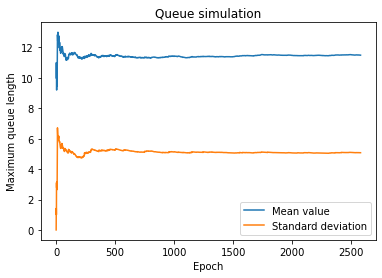

In [4]:
fig, ax = plt.subplots()

ax.plot(q_max_mean_list, label = 'Mean value')
ax.plot(np.sqrt(q_max_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Maximum queue length', title = 'Queue simulation')
ax.legend()

plt.show()

## Bootstrapping

In [5]:
def bootstrap(data, f_statistic, draws):
    """ Calculates the bootstrap mse of a statistic of choice
    
    Keywords:
        data (array): data array.
        f_statistic: function handle calculating the statistic of interest.
        draws (int): number of bootstrap draws.
    
    Returns:
        mse (float): mean square error of the statistic of interest.
    """
    
    theta = f_statistic(data) # Compute the desired statistic over the empirical distribution
    mse = 0 # Initialise the mean square error to 0
    for i in range(draws):
        # Randomly choose samples from the dataset and recompute the statistic of interest
        indexes = np.floor(data.shape[0]*np.random.rand(data.shape[0]))
        samples = data[np.array(indexes).astype(int)]
        # Compute the total squared error
        mse += (theta - f_statistic(samples))**2
    # Take the mean diving by the number of iterations    
    mse = mse/draws
         
    return mse

In [6]:
# Define some function handles calculating statistics of interest
f_mean = lambda data: data.mean()
f_percentile = lambda data: np.quantile(data, 0.95)
f_max = lambda data: max(data)

In [7]:
q_max_list = np.array(q_max_list) # For convenience

# Mean of the maximum queue length
empirical_mean = f_mean(q_max_list) # Equals to q_max_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(q_max_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = q_max_list.var()/q_max_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the maximum queue length
empirical_95p = f_percentile(q_max_list)
print(f'95% percentile: {empirical_95p}')
bootstrap_mse_95p = bootstrap(q_max_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the maximum queue length
empirical_ws = f_max(q_max_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(q_max_list, f_max, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

Mean: 11.492826677006592
Bootstrapped MSE: 0.008503166251230413
Theoretical MSE:  0.009991010293195603

95% percentile: 21.0
Bootstrapped MSE: 0.11786000000000171

Worst case: 35
Bootstrapped MSE: 1.1


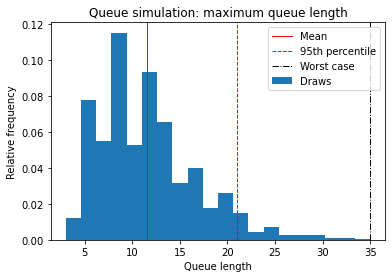

In [8]:
fig, ax = plt.subplots()

ax.hist(q_max_list, density = 1, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Queue length', ylabel = 'Relative frequency', title = 'Queue simulation: maximum queue length')
ax.legend()

plt.show()